Inspriation: [Quelle](https://nzlul.medium.com/the-classification-of-text-messages-using-lstm-bi-lstm-and-gru-f79b207f90ad)<br>
Daten: [Quelle](https://github.com/kitsamho/songlyrics_univeral_sentence_encoder/tree/master/Lyric_data)


## Imports

In [1]:
#%conda install pip
# %pip install -r requirements.txt
# Load, explore and plot data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
# Train test split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# Text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional
from tensorflow.keras.utils import to_categorical


import nltk
from nltk.corpus import stopwords
import re

######## SEED setzen
import random
# Random Seed setzen:
SEED = 49
random.seed(SEED)
np.random.seed(SEED)



label_encoder = LabelEncoder()

## Load Data

In [2]:
load_df = pd.read_csv('preprocessed_split_label.csv', encoding='ISO-8859-1')
load_df.head(3)

,Unnamed: 0,Titel,Lyric,Artist,Genres
0,69,Careless Whisper,feel unsure take hand lead dance floor music d...,Ivete Sangalo,Pop
1,69,Careless Whisper,feel unsure take hand lead dance floor music d...,Ivete Sangalo,AxÃ©
2,69,Careless Whisper,feel unsure take hand lead dance floor music d...,Ivete Sangalo,RomÃ¢ntico


In [3]:
load_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481895 entries, 0 to 481894
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  481895 non-null  int64 
 1   Titel       481893 non-null  object
 2   Lyric       481890 non-null  object
 3   Artist      481895 non-null  object
 4   Genres      481895 non-null  object
dtypes: int64(1), object(4)
memory usage: 18.4+ MB


Lyrics (Data) und Genere (Label) haben keinen Nullwert. Song (-Titel) fehelen 6 aber dass ist egal die können ignoriert werden.

In [4]:
load_df.describe()

,Unnamed: 0
count,481895.000000
mean,168559.061269
std,104536.790228
min,69.000000
25%,63546.500000
50%,165844.000000
75%,266280.000000
max,378987.000000


Funktion zum Plotten der Modell History

Text(0.5, 1.0, 'The distribution of genres')

C:\Users\herbe\anaconda3\envs\NLP_Env\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 130 (\x82) missing from current font.
  func(*args, **kwargs)
C:\Users\herbe\anaconda3\envs\NLP_Env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 130 (\x82) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


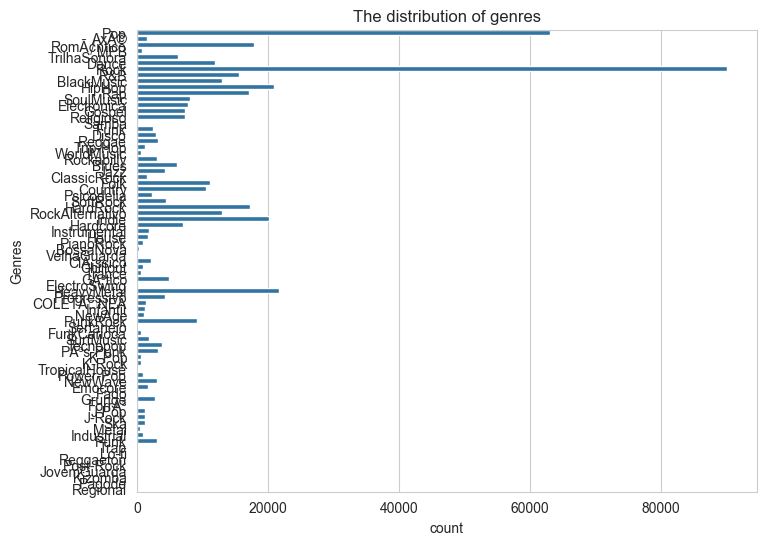

In [5]:
plt.figure(figsize=(8,6))
sns.countplot(load_df.Genres)
plt.title('The distribution of genres')

Genres sehen erst Mal relativ gleichmäßig verteilt aus. Eventuell Später alle auf die ANzahl vom niedrigsten (Hip-Hop) kürzen 

Erstellen des numerischen Labels aus den Genres: 

In [6]:
import pandas as pd

# Assuming the DataFrame 'load_df' is already loaded as you described
# Find the five most common genres
top_genres = load_df['Genres'].value_counts().nlargest(10).index

# Filter the DataFrame to only include rows with the top five genres
df_top_genres = load_df[load_df['Genres'].isin(top_genres)]

# Now df_top_genres contains only the rows where the genre is one of the top five
print(df_top_genres['Genres'].value_counts())

Genres
Rock               90077
Pop                62970
HeavyMetal         21759
HipHop             20902
Indie              20134
RomÃ¢ntico         17947
HardRock           17250
Rap                17114
R&B                15581
RockAlternativo    13061
Name: count, dtype: int64


In [7]:
import pandas as pd

# Assuming the DataFrame 'df' is already loaded as you described
# Specify the genres to drop
#genres_to_keep = ['Gospel/Religioso', 'Jazz', 'Pop/Rock', 'Rock', 'Pop', 'Rap', 'Punk Rock']
genres_to_keep = ['Rock', 'Pop', 'HeavyMetal', 'HipHop', 'Indie', 
                  'Romântico', 'HardRock', 'Rap', 'R&B', 'RockAlternativo']

# Drop rows where the genre column is in the genres_to_drop list
df = load_df[load_df['Genres'].isin(genres_to_keep)]

# Now df_filtered contains only the rows where genre is not 'alternative', 'r&b', 'pop/rock', or 'rock'
print(df['Genres'].value_counts())

Genres
Rock               90077
Pop                62970
HeavyMetal         21759
HipHop             20902
Indie              20134
HardRock           17250
Rap                17114
R&B                15581
RockAlternativo    13061
Name: count, dtype: int64


In [8]:
# to string conversion
df['Titel'] = df['Titel'].astype(str)
df['Lyric'] = df['Lyric'].astype(str)
df['Artist'] = df['Artist'].astype(str)

C:\Users\herbe\AppData\Local\Temp\ipykernel_19436\4219062957.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Titel'] = df['Titel'].astype(str)
C:\Users\herbe\AppData\Local\Temp\ipykernel_19436\4219062957.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lyric'] = df['Lyric'].astype(str)
C:\Users\herbe\AppData\Local\Temp\ipykernel_19436\4219062957.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [13]:
# Count the number of words in the 'Lyric' column
df['lyric_count'] = df['Lyric'].str.split().str.len()

# Normalize the word counts
df['lyric_count_norm'] = df['lyric_count'] / df['lyric_count'].max()*55


C:\Users\herbe\AppData\Local\Temp\ipykernel_19436\464441336.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lyric_count'] = df['Lyric'].str.split().str.len()
C:\Users\herbe\AppData\Local\Temp\ipykernel_19436\464441336.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lyric_count_norm'] = df['lyric_count'] / df['lyric_count'].max()*55


Preprocessing der Daten (lyrics):
- Lowercasing
- Entfernung von Zahlen oder Umwandlung in Text
- Entfernung von Satzzeichen
- Entfernung von Stoppwörtern
- Entfernung von Leerzeichen
- Entfernung von dopplungen: "yeah, yeah, yeah" -> "yeah"

In [10]:
# Sicherstellen, dass NLTK-Ressourcen heruntergeladen sind
nltk.download('stopwords')

# Funktion zur Entfernung von Wiederholungen (z.B. "yeah yeah yeah" -> "yeah")
def remove_repetitions(text):
    # Aufteilen des Texts in Wörter
    words = text.split()
    # Erstellung eines neuen Texts ohne wiederholte Wörter
    new_text = ' '.join(sorted(set(words), key=words.index))
    return new_text

# Funktion zur Bereinigung des Lyrics-Textes
def clean_lyrics(text):

    # Lowercasing
    text = text.lower()
    # Entfernung von Zahlen
    text = re.sub(r'\d+', '', text)
    # Entfernung von Satzzeichen
    text = re.sub(r'[^\w\s]', '', text)
    # Entfernung von mehrfachen Leerzeichen
    text = re.sub(r'\s+', ' ', text)
    # Entfernung von Stoppwörtern
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # Entfernung von Wiederholungen wie "yeah yeah yeah"
    text = remove_repetitions(text)
    return text

# Anwendung der Bereinigungsfunktion auf die Spalte 'lyrics'
df['Lyric'] = df['Lyric'].apply(clean_lyrics)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\herbe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\herbe\AppData\Local\Temp\ipykernel_19436\207609940.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lyric'] = df['Lyric'].apply(clean_lyrics)


In [11]:
df['label'] = label_encoder.fit_transform(df['Genres'])
df.head()

C:\Users\herbe\AppData\Local\Temp\ipykernel_19436\89495988.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = label_encoder.fit_transform(df['Genres'])


,Unnamed: 0,Titel,Lyric,Artist,Genres,lyric_count,lyric_count_norm,label
0,69,Careless Whisper,feel unsure take hand lead dance floor music d...,Ivete Sangalo,Pop,164,0.066424,4
3,86,Could You Be Loved / CitaÃ§Ã£o Musical do Rap:...,dont let fool ya even try school oh weve got m...,Ivete Sangalo,Pop,100,0.040502,4
6,88,Cruisin' (Part. Saulo),baby lets cruise away dont confused way clear ...,Ivete Sangalo,Pop,91,0.036857,4
9,111,Easy,know sounds funny cant stand pain girl im leav...,Ivete Sangalo,Pop,117,0.047388,4
12,140,For Your Babies (The Voice cover),youve got look one hoped lad face beaming smil...,Ivete Sangalo,Pop,99,0.040097,4


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from scipy.sparse import hstack

# Load your data
# df = pd.read_csv('path_to_your_data.csv')

# Assuming the DataFrame 'df' is already loaded as you described
# Preprocessing and vectorization of text data
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_text = vectorizer.fit_transform(df['Lyric'])

# Adding the normalized lyric count as a feature
X_numeric = df[['lyric_count_norm']].values

# Combining text and numeric features
X_combined = hstack([X_text, X_numeric])

# Labels
y = df['Genres']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=42)

# Model training
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Model evaluation
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))
print(f'Accuracy: {accuracy_score(y_test, predictions):.2f}')


                 precision    recall  f1-score   support

       HardRock       0.01      0.00      0.00      5212
     HeavyMetal       0.21      0.13      0.16      6499
         HipHop       0.13      0.13      0.13      6188
          Indie       0.04      0.02      0.03      6119
            Pop       0.29      0.27      0.28     18926
            R&B       0.06      0.03      0.04      4670
            Rap       0.18      0.17      0.17      5086
           Rock       0.28      0.42      0.34     27114
RockAlternativo       0.01      0.00      0.00      3841

       accuracy                           0.23     83655
      macro avg       0.13      0.13      0.13     83655
   weighted avg       0.20      0.23      0.21     83655

Accuracy: 0.23


Print der Accuracy